In [89]:
import keras 
import tensorflow as tf
from keras.datasets import cifar10
import numpy as np
from keras.callbacks import History 
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.callbacks import History 
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from google.colab import files #para bajar imagenes del google colabs p/ informe
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras import applications

In [90]:
#cargo un modelo pre entrenado de keras como base, por ejemplo, la vgg16
#que tambien es la que usamos en el ejercicio anterior
model =  VGG16(include_top=False,weights='imagenet')

In [91]:
model.summary() #summary donde vemos todos los bloques de la vgg16

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Mapas de activacion primero**

In [92]:
tf.compat.v1.disable_eager_execution()

In [93]:
def deprocess_img(x):
  x -= x.mean()
  x /= (x.std() +1e-7)
  x *= .1
  x += .5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [94]:
def act_map(layer_name,filt_index):
  #layer_name es el nombre de la capa a analisar
  #filt_index es el indice del filtro de esa capa
  img_data = np.random.random((1,224,224,3)) * 20 + 128 #arrancamos con una imagen sintetica (gris con algo de ruido)
  layer = model.get_layer(layer_name)
  activation = layer.output
  loss = K.mean(activation[..., filt_index])
  grads = K.gradients(loss, model.input)[0]
  # Truco de normalizacion
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6)
  run = K.function([model.input], [loss, grads])
  #maximizamos con gradiente ascendente
  step = 1
  for i in range(40): 
    loss_val, grads_val = run([img_data])
    img_data += grads_val * step
     #print('step:{:03d}\t loss:{:.3f}'.format(i, loss_val))
  img = img_data[0]
  img = deprocess_img(img)
  keras.preprocessing.image.save_img(str(layer_name)+'_' +str(filt_index)+'.pdf', img)

In [96]:
lista_capas = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
numero_filtro = np.arange(10)
for capas in lista_capas:
  layer_name = capas
  for i in numero_filtro:
    filt_index = i
    act_map(layer_name,filt_index)
    

visualizacion de los filtros en si (son 3 imgs (RGB) de 3x3 por cada filtro)

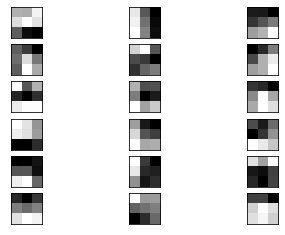

<Figure size 432x288 with 0 Axes>

In [124]:
# retrieve weights from the second hidden layer
lname = 'block5_conv3'
filters, biases = model.get_layer(lname).get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()
plt.savefig('block5_conv3_6_filters.pdf')